## Plot Timer Results
To understand runtimes implications for each algorithm, plot their runtimes side by side by running the notebook from start to finish.

training runtimes
|                             | Runtime (Seconds)   |
|:----------------------------|:--------------------|
| LogisticRegression          | 1.572e-02±0.003     |
| SGDClassifier               | 6.893e-03±0.001     |
| MLPClassifier_0.1           | 1.734e-01±0.012     |
| XGBRFClassifier_10          | 1.657e-01±0.004     |
| FedAvg SGDClassifier        | 1.460e+01±1.422     |
| FedAvg XGBRFClassifier      | 1.061e+01±0.009     |
| FedAvg LRClassifier         | 8.182e+00±0.774     |
| FedAvg MLPClassifier        | 8.746e+00±0.124     |
| FedProx μ = 0 LRClassifier  | 8.636e+00±0.163     |
| FedProx μ = 0 MLPClassifier | 8.892e+00±0.153     |
| FedProx μ = 2 LRClassifier  | 8.947e+00±0.141     |
| FedProx μ = 2 MLPClassifier | 9.190e+00±0.196     |


/tmp/ipykernel_72331/317443729.py:131: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  m_df = t.transpose().applymap(lambda x: '{0:.3e}'.format(x))
/tmp/ipykernel_72331/317443729.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  std_df = t.transpose().applymap(lambda x: '{0:.3f}'.format(x))


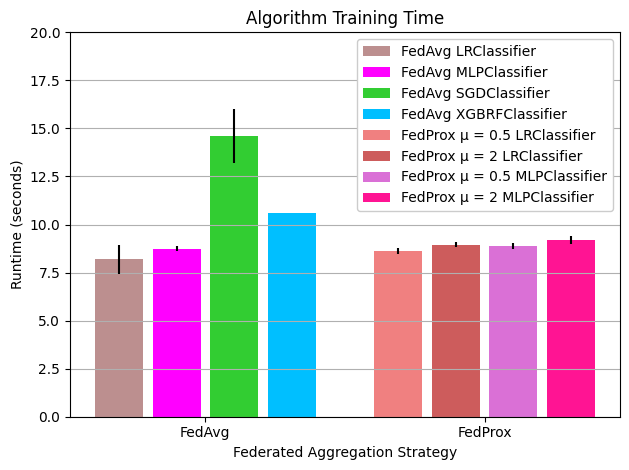

In [8]:
import pickle
import collections
import numpy as np

def create_runtime_figure_and_table(timer_directory_path: str, output_dir: str):
    
    
    runtime_logs = dict(pickle.load(open(f"{timer_directory_path}/time_logs.pkl", 'rb')))

    reduced = collections.defaultdict(list)
    for row, value in runtime_logs.items():
        fold_idx, alg_name, dataset_name = row
        # print(dataset_name)
        reduced[(alg_name)].extend([value])

    means, stds = {}, {}
    for alg, vals in reduced.items():
        mean = np.mean(vals)
        means[alg] = mean

        std = np.std(vals)
        stds[alg] = std

    # display(stds)
    # display(means)
    exclusion_set = ['FedProx μ = 5 MLPClassifier', 'FedProx μ = 8 MLPClassifier', 'FedProx μ = 5 LRClassifier', 'FedProx μ = 8 LRClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'SVC', 'KNeighborsClassifier', 'LinearDiscriminantAnalysis', 'QuadraticDiscriminantAnalysis', 'BaggingClassifier', 'XGBClassifier']
    # not included in figure
    cent = ['LogisticRegression', 'SGDClassifier', 'MLPClassifier_0.1', 'XGBRFClassifier_10']
    fedavg = ['FedAvg SGDClassifier', 'FedAvg XGBRFClassifier', 'FedAvg LRClassifier', 'FedAvg MLPClassifier']
    fedprox = [alg_name for alg_name in means if alg_name not in fedavg and alg_name not in exclusion_set and alg_name not in cent]
    # display(fedavg)
    # display(fedprox)

    import matplotlib.pyplot as plt

    def sort_name(name):
        if "X" in name:
            return "X"
        loc = name.find("Classifier")
        return name[loc-3:]

    colors = {
        'FedAvg LRClassifier': 'rosybrown',
        'FedProx μ = 0 LRClassifier': 'lightcoral', # 0.5
        'FedProx μ = 2 LRClassifier': 'indianred',
        'FedProx μ = 5 LRClassifier': 'firebrick',
        'FedProx μ = 8 LRClassifier': 'maroon',

        'FedAvg MLPClassifier': 'magenta',
        'FedProx μ = 0 MLPClassifier': 'orchid', # 0.5
        'FedProx μ = 2 MLPClassifier': 'deeppink',
        'FedProx μ = 5 MLPClassifier': 'hotpink',
        'FedProx μ = 8 MLPClassifier': 'pink',

        'FedAvg SGDClassifier': 'limegreen',

        'FedAvg XGBRFClassifier': 'deepskyblue',

        # 'LogisticRegression': 'salmon',
        # 'SGDClassifier': 'salmon',
        # 'MLPClassifier_0.1': 'salmon',
        # 'XGBClassifier': 'salmon',
        # 'XGBRFClassifier_10': 'salmon'
    }

    # Set the width of each bar within a group
    bar_width = 0.5
    gap_between_groups = 0.1

    # Create a list of x positions for each group
    x_positions = range(len(means))

    # Create a figure and an Axes object
    fig, ax = plt.subplots()

    # Iterate through each group and plot the bars with custom colors
    # for i, group_name in enumerate(barchart_performance_groups):
    #     x = [pos + i * bar_width for pos in x_positions]
    #     bars = ax.bar(x, bar_values[i], bar_width, label=group_name, color=bar_colors[i])

    x_ticks = []
    loc = 0.5
    for i, group in enumerate([fedavg, fedprox]):

        group_start = loc
        for j, alg_name in enumerate(sorted(group, key=sort_name)):
            
            score = means[alg_name]
            error = stds[alg_name]

            label = alg_name.replace("FedProx μ = 0", "FedProx μ = 0.5") if "FedProx μ = 0" in alg_name else alg_name
            ax.bar(loc, score, bar_width, label=label, color=colors[alg_name], yerr=error, align='edge')
            
            loc += bar_width + gap_between_groups
        
        group_end = loc - gap_between_groups
        group_center = (group_start + group_end) / 2
        x_ticks.append(group_center)

        loc += 0.5

    # Customize the plot
    ax.set_xlabel(f'Federated Aggregation Strategy')
    ax.set_ylabel('Runtime (seconds)')
    ax.set_title(f'Algorithm Training Time')
    ax.set_xticks(x_ticks)
    x_tick_positions = [1.64, 4.555]
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(['FedAvg', 'FedProx'], fontsize=10, rotation_mode="anchor")
    ax.grid(axis='y')

    plt.ylim(0, 20)

    ax.legend(ncols=1, loc='upper right', framealpha=1)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"{output_dir}/runtime.png")

    import pandas as pd
    # filter means
    means = {k: v for k, v in means.items() if any([k in cent, k in fedavg, k in fedprox])}

    m_df = pd.DataFrame([means], index=[0])
    # display(m_df.shape)

    t = m_df
    t['Algorithm Name'] = ['Runtime (Seconds) mean']
    t.set_index('Algorithm Name', drop=True, inplace=True)

    m_df = t.transpose().applymap(lambda x: '{0:.3e}'.format(x))
    # m_df = t.transpose().astype(str)

    stds = {k: v for k, v in stds.items() if any([k in cent, k in fedavg, k in fedprox])}
    std_df = pd.DataFrame([stds], index=[0])
    # display(std_df.shape)

    t = std_df
    t['Algorithm Name'] = ['Runtime (Seconds) std']
    t.set_index('Algorithm Name', drop=True, inplace=True)

    std_df = t.transpose().applymap(lambda x: '{0:.3f}'.format(x))
    # std_df = t.transpose().astype(str)

    combined = pd.concat([m_df, std_df], axis=1)
    combined['Runtime (Seconds)'] = combined['Runtime (Seconds) mean'] + "±" + combined['Runtime (Seconds) std']
    combined = combined.drop(columns=['Runtime (Seconds) mean', 'Runtime (Seconds) std'])
    combined.to_csv(f'{output_dir}/runtime.csv')

    print("=========================================")
    print("training runtimes")
    print(combined.to_markdown())

# REPLACE WITH YOUR OWN PATH
# path which contains the result of running timed experiments
TIMER_DIRECTORY_PATH = '/home/bdanek2/multi-omics-pdd-FL-study/federated_learning_multi_modality_ancestry/multi_modality_fl/results/experiment_logs/timed_experiments_uniform_strat'

# REPLACE WITH YOUR OWN PATH
# path which you want to write figures and tables to
OUTPUT_PATH = "/home/bdanek2/multi-omics-pdd-FL-study/federated_learning_multi_modality_ancestry/multi_modality_fl/results/repro-generated_figures_tables"
create_runtime_figure_and_table(TIMER_DIRECTORY_PATH, OUTPUT_PATH)